# Similarity Analysis Notebook

## Imports

In [1]:
!pip install datasketch
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from datasketch import MinHash, MinHashLSH
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [3]:
def calculate_minHashLsh(df):

    # Create text features
    df["text_features"] = df["song"] + " " + df["artist"]
    # Build MinHashes
    minhashes_text = {i: create_minhash(txt) for i, txt in enumerate(df["text_features"])}
    # Build LSH index
    lsh_text = MinHashLSH(threshold=0.2, num_perm=128)
    for i, m in minhashes_text.items():
        lsh_text.insert(str(i), m)
    # Numeric cosine similarity
    num_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(df[num_cols])
    cosine_sim = cosine_similarity(scaled_values)
    return cosine_sim, minhashes_text, lsh_text

# Build MinHash for text features
def create_minhash(text, num_perm=128):
    m = MinHash(num_perm=num_perm)
    for word in text.split():
        m.update(word.encode("utf8"))
    return m

def generate_correlation_matrix(dataframe):
    dfh1 = dataframe[["popularity", "danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness",
               "liveness", "valence", "tempo"]]
    corr = dfh1.corr(numeric_only=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap="Spectral", center=0)
    plt.xticks(rotation=45, ha="right", fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.title("Correlation Matrix of Audio Features", fontsize=14, pad=15)
    plt.tight_layout()
    plt.show()

In [4]:
# Load and clean dataset
df = pd.read_csv("songs_normalize.csv")
# Normalize column names
df.columns = (
    df.columns
    .str.strip()             # remove leading/trailing spaces
    .str.lower()             # lowercase all
    .str.replace(" ", "_")   # replace spaces with underscores
    .str.replace("-", "_")   # replace hyphens with underscores
)

# Clean data
# Drop duplicates
df.drop_duplicates(inplace=True)

# Remove rows missing essential fields
df.dropna(subset=["song", "artist"], inplace=True)
df.reset_index(drop=True, inplace=True)
# Normalize text (lowercase + strip spaces)
df["song"] = df["song"].astype(str).str.lower().str.strip()
df["artist"] = df["artist"].astype(str).str.lower().str.strip()

# Fill missing numeric values (if any)
num_cols = df.select_dtypes(include=[np.number]).columns
if len(num_cols) > 0:
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Display summary
print(f"Dataset after cleaning procedure: {df.shape[0]} rows, {df.shape[1]} columns")
print(df.head(3))

print(df.describe().T)

Dataset after cleaning procedure: 1941 rows, 18 columns
           artist                    song  duration_ms  explicit  year  \
0  britney spears  oops!...i did it again       211160     False  2000   
1       blink-182    all the small things       167066     False  1999   
2      faith hill                 breathe       250546     False  1999   

   popularity  danceability  energy  key  loudness  mode  speechiness  \
0          77         0.751   0.834    1    -5.444     0       0.0437   
1          79         0.434   0.897    0    -4.918     1       0.0488   
2          66         0.529   0.496    7    -9.007     1       0.0290   

   acousticness  instrumentalness  liveness  valence    tempo         genre  
0        0.3000          0.000018     0.355    0.894   95.053           pop  
1        0.0103          0.000000     0.612    0.684  148.726     rock, pop  
2        0.1730          0.000000     0.251    0.278  136.859  pop, country  
                   count           mean   

In [6]:
def get_similar_songs(df, song_index, cosine_sim, minhashes_text, lsh_text, top_n=5, weight_text=0.2, weight_numeric=0.8):
    """Combine text-LSH and numeric cosine similarity using precomputed data."""
    text_query = minhashes_text[song_index]
    text_candidates = [int(i) for i in lsh_text.query(text_query) if int(i) != song_index]

    if len(text_candidates) < 10:
        text_candidates = list(range(len(df)))

    combined_scores = []
    for idx in text_candidates:
        # Skip identical song
        if (
            df.iloc[idx]["song"] == df.iloc[song_index]["song"]
            and df.iloc[idx]["artist"] == df.iloc[song_index]["artist"]
        ):
            continue
        text_sim = text_query.jaccard(minhashes_text[idx])
        num_sim = cosine_sim[song_index, idx]
        score = weight_text * text_sim + weight_numeric * num_sim
        combined_scores.append((idx, score))

    combined_scores = sorted(combined_scores, key=lambda x: x[1], reverse=True)[:top_n]
    results = [
        (df.iloc[i]["song"], df.iloc[i]["artist"], df.iloc[i]["popularity"], score)
        for i, score in combined_scores
    ]
    return results

def find_similar_songs(df, song_index, cosine_sim, minhashes_text, lsh_text, top_n=5):
    # Print similar songs for a single track
    similar_songs = get_similar_songs(df, song_index, cosine_sim, minhashes_text, lsh_text, top_n=top_n)
    print(f"\n Similar songs to '{df.iloc[song_index]['song']}' by {df.iloc[song_index]['artist']}:\n")
    for name, artist, pop, score in similar_songs:
        print(f"  - Title: {name}| Artist: {artist} | Popularity: {pop} | Similarity: {score:.3f}")


def find_similar_songs_of_top_popular_songs(df, cosine_sim, minhashes_text, lsh_text, top_popular_songs=10, top_n=5):
    """
    Find top-N similar songs for each of the most popular songs.
    Returns a dictionary where keys are song indices and values are lists of
    (song, artist, popularity, similarity_score) tuples.
    """
    top_popular_songs = df.sort_values(by="popularity", ascending=False).head(top_popular_songs)
    pos_indices = [df.index.get_loc(label) for label in top_popular_songs.index]

    print(f"Top {top_popular_songs.shape[0]} Popular Songs and Their Most Similar Tracks:\n")
    results = {}

    for pos in pos_indices:
        song_name = df.iloc[pos]["song"]
        artist_name = df.iloc[pos]["artist"]
        popularity = df.iloc[pos]["popularity"]

        # Get full recommendation info (including similarity)
        similar_songs = get_similar_songs(df, pos, cosine_sim, minhashes_text, lsh_text, top_n=top_n)

        results[pos] = similar_songs  # <-- keep full tuples here

        print(f"\n '{song_name}' by {artist_name} (Popularity: {popularity})\n")
        for name, artist, pop, score in similar_songs:
            print(f"  - Title: {name}| Artist: {artist} | Popularity: {pop} | Similarity: {score:.3f}")

    return results


def genre_similarity_analysis(df, cosine_sim, minhashes_text, lsh_text, genre_col="genre", sample_size=200):
    genres = df[genre_col].dropna().unique()
    genre_scores = {g: [] for g in genres}
    indices = np.random.choice(len(df), sample_size, replace=False)

    for idx in indices:
        sims = get_similar_songs(df, idx, cosine_sim, minhashes_text, lsh_text, top_n=5)
        g = df.iloc[idx][genre_col]
        # Only count similarity within the same genre
        genre_scores[g].extend([s[-1] for s in sims if df.iloc[idx][genre_col] == g])

    # Compute average similarity per genre
    avg_scores = {g: np.mean(v) for g, v in genre_scores.items() if v}

    print("\n Average Similarity by Genre:")
    for g, s in sorted(avg_scores.items(), key=lambda x: -x[1]):
        print(f"  - {g}: {s:.3f}")

    # --- Find the most and least similar genres ---
    if avg_scores:
        most_similar_genre = max(avg_scores, key=avg_scores.get)
        least_similar_genre = min(avg_scores, key=avg_scores.get)

        print("\n Most Similar Genre:")
        print(f"  - {most_similar_genre}: {avg_scores[most_similar_genre]:.3f}")

        print("\n Least Similar Genre:")
        print(f"  - {least_similar_genre}: {avg_scores[least_similar_genre]:.3f}")

    return avg_scores


def recommend_similar_songs_based_on_your_favorites(df, user_favorites, cosine_sim, minhashes_text, lsh_text, top_n=5):
    """
    Generate personalized song recommendations based on user's favorite songs.
    - user_favorites: list of song indices or song names (case-insensitive)
    """
    recommendations = {}

    for fav in user_favorites:
        # Handle both index and song name
        if isinstance(fav, int):
            idx = fav
        else:
            matches = df.index[df["song"].str.lower() == fav.lower()].tolist()
            if not matches:
                print(f" Song '{fav}' not found in dataset. Skipping.")
                continue
            idx = matches[0]

        # Find similar songs
        similar = get_similar_songs(df, idx, cosine_sim, minhashes_text, lsh_text, top_n=top_n)
        for s, a, pop, score in similar:
            key = f"{s} by {a}"
            if df.iloc[idx]["song"] == s and df.iloc[idx]["artist"] == a:
                continue
            recommendations[key] = max(recommendations.get(key, 0), score)

    # Sort recommendations by descending similarity score
    recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    print("\nPersonalized Recommendations:")

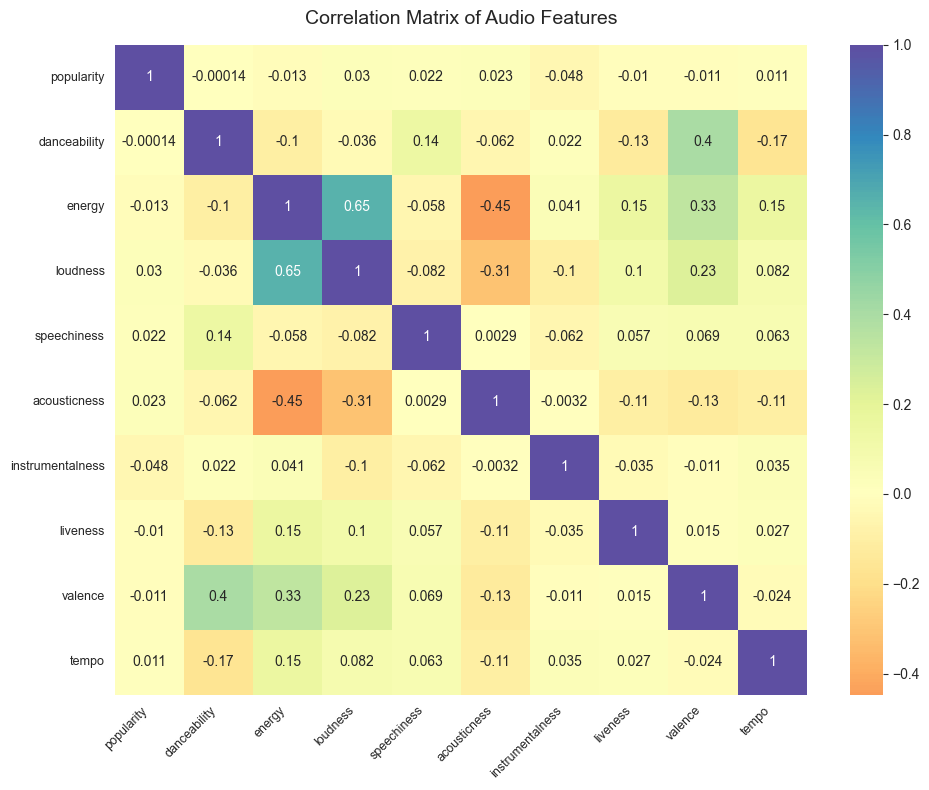


 Average Similarity by Genre:
  - R&B: 0.820
  - rock, metal: 0.818
  - pop, latin: 0.813
  - rock, easy listening: 0.810
  - hip hop, Dance/Electronic: 0.810
  - hip hop, pop, Dance/Electronic: 0.807
  - hip hop, pop, latin: 0.806
  - pop, Dance/Electronic: 0.804
  - pop: 0.800
  - rock: 0.799
  - pop, country: 0.799
  - pop, rock, Dance/Electronic: 0.798
  - rock, blues: 0.798
  - hip hop, pop, R&B: 0.797
  - hip hop, pop: 0.795
  - rock, pop: 0.794
  - metal: 0.793
  - pop, Folk/Acoustic: 0.792
  - hip hop: 0.792
  - pop, rock: 0.790
  - country: 0.790
  - Dance/Electronic: 0.787
  - rock, pop, Dance/Electronic: 0.785
  - hip hop, R&B: 0.785
  - pop, R&B: 0.785

 Most Similar Genre:
  - R&B: 0.820

 Least Similar Genre:
  - pop, R&B: 0.785


{'pop': np.float64(0.8002684973195682),
 'rock, pop': np.float64(0.7941920716042221),
 'pop, country': np.float64(0.7989600069427193),
 'rock, metal': np.float64(0.8176282500392293),
 'hip hop, pop, R&B': np.float64(0.7970141169492077),
 'hip hop': np.float64(0.7915250199003296),
 'pop, rock': np.float64(0.7901268414557201),
 'pop, R&B': np.float64(0.7845703536769977),
 'Dance/Electronic': np.float64(0.7872467762342854),
 'pop, Dance/Electronic': np.float64(0.8043294957757319),
 'metal': np.float64(0.7932651824738264),
 'hip hop, pop': np.float64(0.795499135284195),
 'R&B': np.float64(0.8201266528686896),
 'pop, latin': np.float64(0.8128747747285697),
 'rock': np.float64(0.7994418141081856),
 'hip hop, R&B': np.float64(0.7850025910654065),
 'pop, Folk/Acoustic': np.float64(0.792448917166011),
 'hip hop, pop, latin': np.float64(0.8062072996666763),
 'hip hop, Dance/Electronic': np.float64(0.8101197860114364),
 'rock, easy listening': np.float64(0.8103128219493257),
 'rock, blues': np.fl

In [7]:
generate_correlation_matrix(df)
cosine_sim, minhashes_text, lsh_text = calculate_minHashLsh(df)
# Hybrid similarity
# Trade off between weight_text and weight_numeric
genre_similarity_analysis(df, cosine_sim, minhashes_text, lsh_text)

In [8]:
song_index = 1  # pick any song
top_n = 10
find_similar_songs(df, song_index, cosine_sim, minhashes_text, lsh_text, top_n)
top_popular_songs = 5
popular_recomm = find_similar_songs_of_top_popular_songs(df, cosine_sim, minhashes_text, lsh_text, top_popular_songs=top_popular_songs, top_n=top_n)
for k, v in list(popular_recomm.items())[:2]:
    print("Key (song index):", k)
    print("First element in value list:", v[0])
    break

# Define user's favorite playlist
user_favorites_playlist = ["another love", "Someone You Loved", "In the Name of Love", "Starboy", "Sin Pijama", "Hello"]
# Find top 10 recommendations bas
recommendations = recommend_similar_songs_based_on_your_favorites(df, user_favorites_playlist, cosine_sim, minhashes_text, lsh_text, top_n=top_n)


 Similar songs to 'all the small things' by blink-182:

  - Title: all the right moves| Artist: onerepublic | Popularity: 65 | Similarity: 0.817
  - Title: turn off the light| Artist: nelly furtado | Popularity: 1 | Similarity: 0.792
  - Title: you're gonna go far, kid| Artist: the offspring | Popularity: 78 | Similarity: 0.788
  - Title: evacuate the dancefloor| Artist: cascada | Popularity: 63 | Similarity: 0.785
  - Title: feel the love (feat. john newman)| Artist: rudimental | Popularity: 64 | Similarity: 0.781
  - Title: don't stop the party (feat. tjr)| Artist: pitbull | Popularity: 64 | Similarity: 0.781
  - Title: chained to the rhythm| Artist: katy perry | Popularity: 69 | Similarity: 0.780
  - Title: all night| Artist: the vamps | Popularity: 73 | Similarity: 0.775
  - Title: superheroes| Artist: the script | Popularity: 74 | Similarity: 0.773
  - Title: the nights| Artist: avicii | Popularity: 85 | Similarity: 0.771
Top 5 Popular Songs and Their Most Similar Tracks:


 'swe

In [ ]:
def visualize_recommendations_pca(df, user_favorites, recommendations, n_components=2):

    print("\nVisualizing personalized recommendations in song feature space...")

    # Reduce numeric features to 2D
    num_cols = df.select_dtypes(include=[np.number]).columns
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(df[num_cols])
    reducer = PCA(n_components=n_components)
    reduced = reducer.fit_transform(scaled_values)

    # Base plot
    plt.figure(figsize=(10, 7))
    plt.scatter(reduced[:, 0], reduced[:, 1], s=30, alpha=0.3, label="All Songs")

    # Plot favorites
    favorite_indices = []
    for fav in user_favorites:
        if isinstance(fav, int):
            favorite_indices.append(fav)
        else:
            matches = df.index[df["song"].str.lower() == fav.lower()].tolist()
            if matches:
                favorite_indices.append(matches[0])

    plt.scatter(reduced[favorite_indices, 0], reduced[favorite_indices, 1],
                color="red", s=80, label="Your Favorites")

    # Plot recommended songs
    rec_names = [r[0].split(" by ")[0] for r in recommendations]
    rec_indices = df[df["song"].isin(rec_names)].index.tolist()

    plt.scatter(reduced[rec_indices, 0], reduced[rec_indices, 1],
                color="green", s=70, label="Recommendations")

    plt.legend()
    plt.title("Personalized Recommendation Map")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Bar Plot for Recommended Songs
# -----------------------------
def visualize_recommendations_barplot(user_favorites, recommendations, df):
    """
    Visualize top recommended songs for user favorites.
    """

    import re
    from matplotlib.patches import Patch

    if not recommendations:
        print("No recommendations to visualize.")
        return

    # Normalize text for matching
    def norm(s):
        return re.sub(r"\s+", " ", str(s).strip().lower())

    # Collect favorite artists
    fav_artists = set()
    for fav in user_favorites:
        fav_norm = norm(fav)
        if " by " in fav_norm:
            song_part, artist_part = fav_norm.split(" by ", 1)
            matches = df[
                (df["song"].apply(norm) == song_part) &
                (df["artist"].apply(norm) == artist_part)
            ]
        else:
            matches = df[df["song"].apply(norm) == fav_norm]

        if not matches.empty:
            fav_artists.update(matches["artist"].apply(norm))

    # Extract recommendation metadata
    rec_names = [r[0] for r in recommendations]
    rec_scores = [float(r[1]) for r in recommendations]

    # Extract artist names from "song by artist"
    rec_artists = []
    for name in rec_names:
        parts = norm(name).rsplit(" by ", 1)
        rec_artists.append(parts[-1] if len(parts) == 2 else "")

    # Colors: same artist = blue, different = green
    colors = ["dodgerblue" if a in fav_artists else "mediumseagreen"
              for a in rec_artists]

    # Plot
    fig, ax = plt.subplots(figsize=(14, 7))
    bars = ax.barh(range(len(rec_names)), rec_scores, color=colors, alpha=0.9)
    ax.invert_yaxis()

    # Add score text
    for i, bar in enumerate(bars):
        ax.text(
            bar.get_width() + 0.008,
            bar.get_y() + bar.get_height() / 2,
            f"{rec_scores[i]:.3f}",
            va="center",
            fontsize=10
        )

    ax.set_yticks(range(len(rec_names)))
    ax.set_yticklabels(rec_names, fontsize=10, ha="right")
    ax.set_xlabel("Similarity Score")
    ax.set_xlim(0, max(rec_scores) + 0.08)
    ax.set_title(f"Top Recommended Songs Based on Favorites:\n{', '.join(user_favorites)}",
                 fontsize=15, fontweight="bold", pad=20)

    # Legend
    legend_patches = [
        Patch(color="dodgerblue", label="Same Artist as Favorite"),
        Patch(color="mediumseagreen", label="Different Artist"),
    ]
    ax.legend(handles=legend_patches, fontsize=10, frameon=False,
              loc="center left", bbox_to_anchor=(1.01, 0.5))

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# -----------------------------
# Pie Chart: Favorite Song Genre Distribution
# -----------------------------
def visualize_favorite_genre_distribution(df, user_favorites):

    fav_rows = []
    for fav in user_favorites:
        match = df[df["song"].str.lower() == fav.lower()]
        if not match.empty:
            fav_rows.append(match.iloc[0])

    if not fav_rows:
        print("No favorites found in dataset.")
        return

    fav_df = pd.DataFrame(fav_rows)
    genre_counts = fav_df["genre"].value_counts()

    plt.figure(figsize=(7, 7))
    plt.pie(genre_counts, labels=genre_counts.index,
            autopct="%1.1f%%", startangle=90)
    plt.title("Genre Distribution of Your Favorite Songs")
    plt.show()

# -----------------------------
# Radar Plot for Favorite Songs (Comparing Audio Features)
# -----------------------------
def radar_plot_favorites(df, user_favorites):

    features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

    fav_rows = []
    labels = []

    for fav in user_favorites:
        match = df[df["song"].str.lower() == fav.lower()]
        if not match.empty:
            row = match.iloc[0]
            fav_rows.append(row[features].values)
            labels.append(f"{row['song']} - {row['artist']}")

    if not fav_rows:
        print("Favorites not found.")
        return

    fav_data = np.array(fav_rows)

    # Normalize features
    scaler = MinMaxScaler()
    fav_norm = scaler.fit_transform(fav_data)

    # Setup angles for radar
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)

    for values, label in zip(fav_norm, labels):
        vals = values.tolist()
        vals += vals[:1]
        ax.plot(angles, vals, linewidth=2, label=label)
        ax.fill(angles, vals, alpha=0.15)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=12)
    ax.set_title("Audio Feature Characteristics of Favorite Songs", fontsize=15, pad=20)
    ax.set_rlabel_position(30)

    plt.legend(loc="lower right", bbox_to_anchor=(1.45, -0.05))
    plt.show()


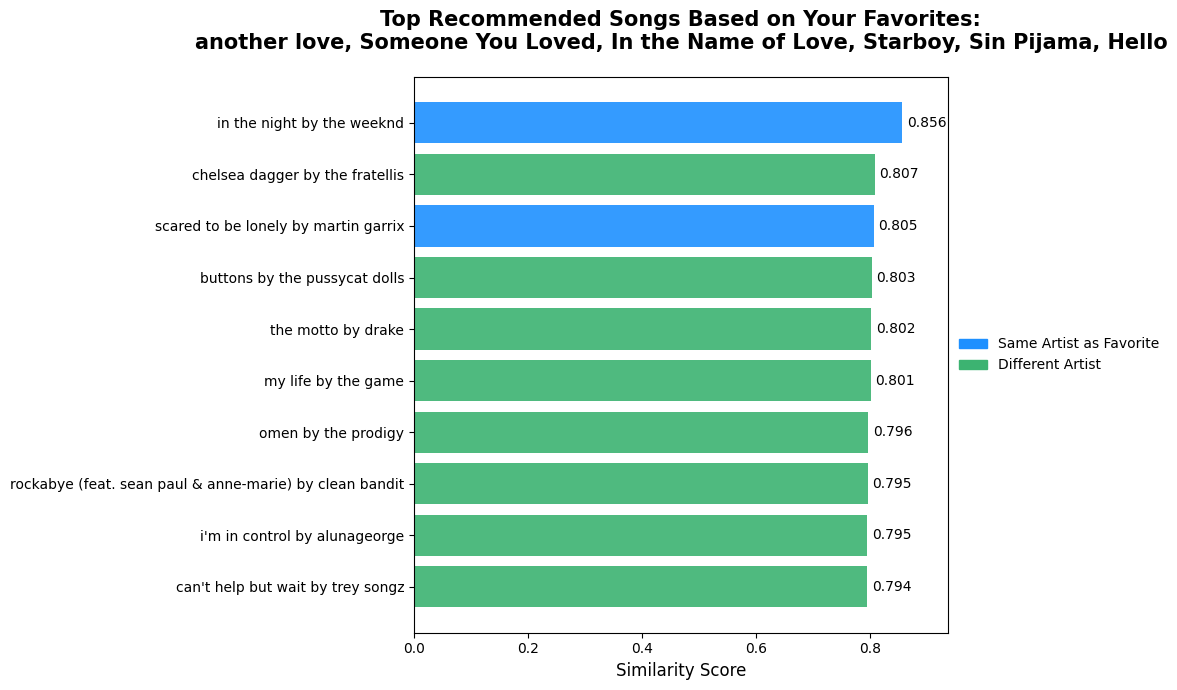

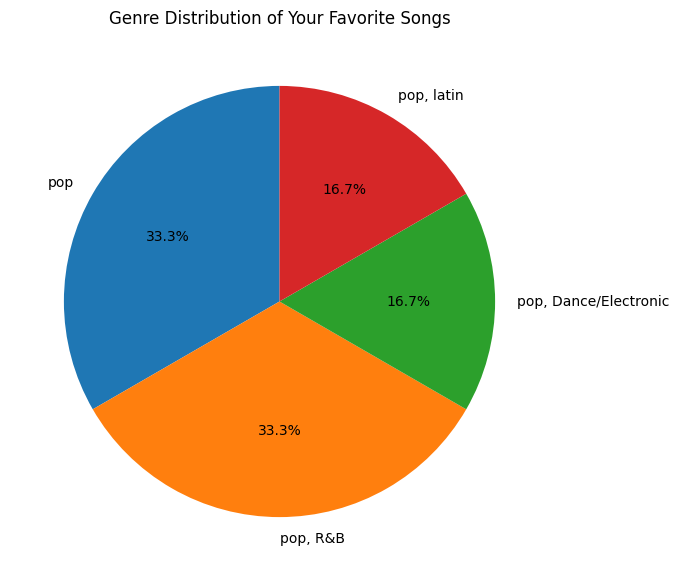


Visualizing personalized recommendations in song feature space...


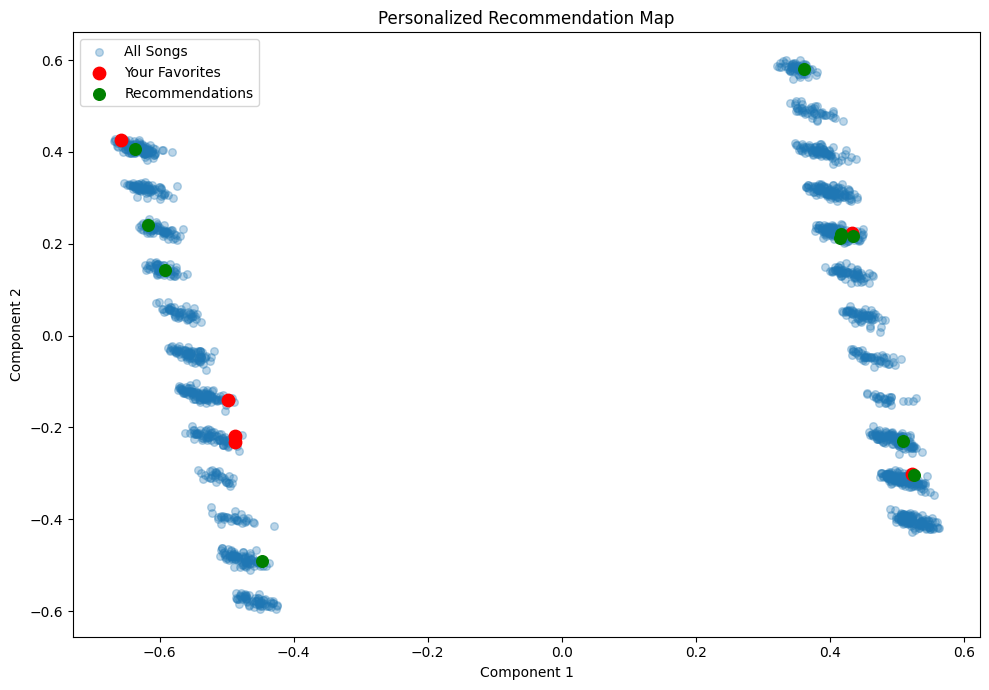

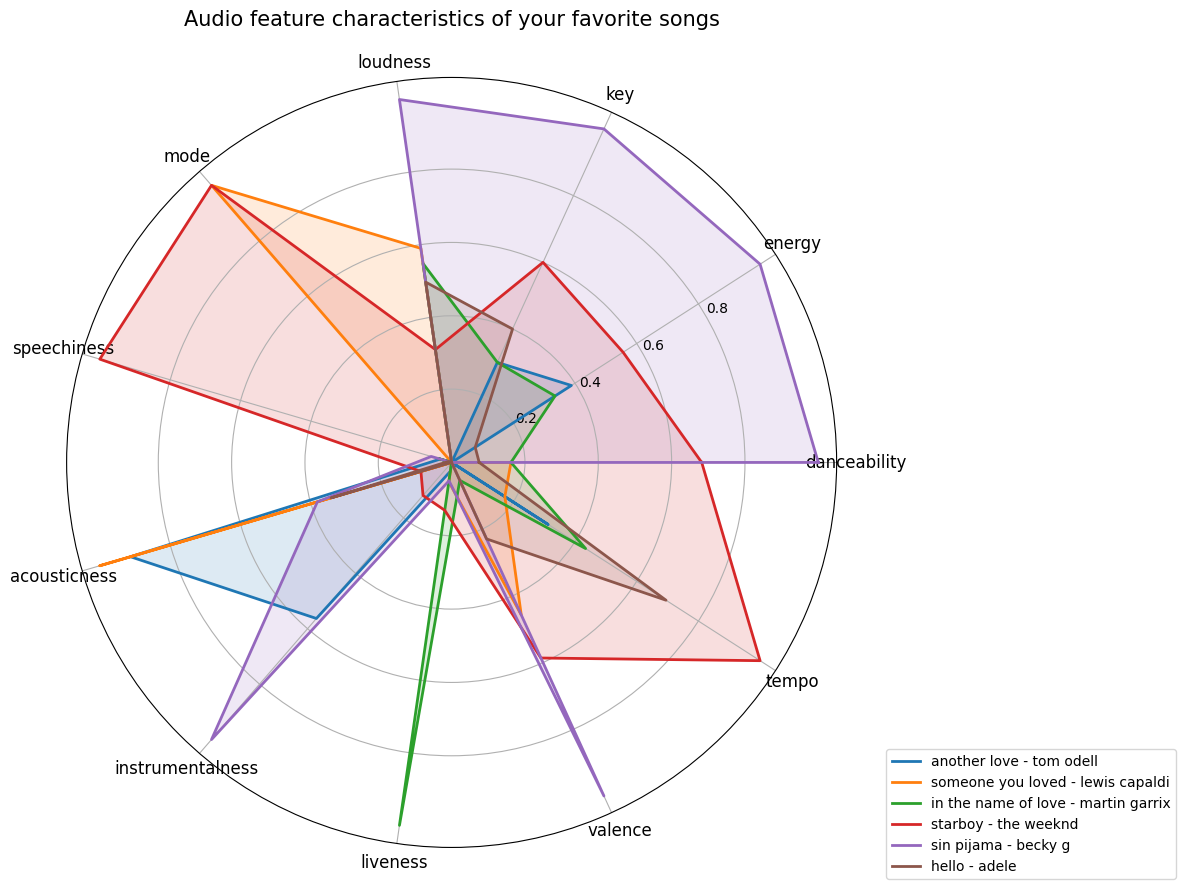

In [24]:
visualize_recommendations_barplot(user_favorites_playlist, recommendations, df)
visualize_favorite_genre_distribution(df, user_favorites_playlist)
visualize_recommendations_pca(df, user_favorites_playlist, recommendations, n_components=2)
radar_plot_favorites(df, user_favorites_playlist)